In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from tqdm import tqdm
import time
from math import comb
import cupy as cp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import filters, measure
from skimage import img_as_float
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim


# Functions

In [3]:
import numpy as np

def center_crop(img: np.ndarray, out_h: int, out_w: int) -> np.ndarray:
    """
    Recorta centrado sin redimensionar.
    img: array (H, W, C) o (H, W)
    out_h, out_w: tamaño deseado (<= H, <= W)
    """
    H, W = img.shape[:2]
    assert out_h <= H and out_w <= W, "El tamaño de salida no puede superar al de la imagen."
    top  = (H - out_h) // 2
    left = (W - out_w) // 2
    return img[top:top+out_h, left:left+out_w, ...]


def center_crop_to_common_size(images: list[np.ndarray]) -> list[np.ndarray]:
    """
    Recorta todas las imágenes al tamaño común máximo posible:
    (min alto, min ancho) entre ellas, centrado.
    """
    # soporta tanto (H,W,C) como (H,W)
    heights = [im.shape[0] for im in images]
    widths  = [im.shape[1] for im in images]
    out_h, out_w = min(heights), min(widths)
    return [center_crop(im, out_h, out_w) for im in images]


def center_crop_to(images: list[np.ndarray], target_hw: tuple[int, int]) -> list[np.ndarray]:
    """
    Recorta todas las imágenes al tamaño exacto target_hw=(H,W), centrado.
    Úsalo solo si todas las imágenes son al menos tan grandes como el target.
    """
    out_h, out_w = target_hw
    return [center_crop(im, out_h, out_w) for im in images]


In [4]:
def registrationSimple(image2, zf):
    # Assuming image2 is 2D (grayscale)
    s = (zf, zf)
    output_shape = tuple(np.round(np.array(image2.shape) * s).astype(int))

    # diff is (original_H - zoomed_H, original_W - zoomed_W)
    diff = np.array(image2.shape) - np.array(output_shape)

    final_image_canvas = np.zeros_like(image2)

    if diff[0]>0 and diff[1]>0: # Original is larger than zoomed (zf < 1), so we need to pad the zoomed content
        zoomed_content = scipy.ndimage.zoom(image2, s, mode='constant', cval=0)
        # Calculate padding needed
        pad_y_start = diff[0] // 2
        pad_x_start = diff[1] // 2
        # Place zoomed content in the center of the original-sized canvas
        final_image_canvas[pad_y_start : pad_y_start + zoomed_content.shape[0],
                           pad_x_start : pad_x_start + zoomed_content.shape[1]] = zoomed_content
        return final_image_canvas
    elif diff[0]<0 and diff[1]<0: # Original is smaller than zoomed (zf > 1), so we need to crop the zoomed content
        zoomed_content = scipy.ndimage.zoom(image2, s, mode='constant', cval=0)
        # Calculate cropping boundaries
        crop_y_start = -diff[0] // 2
        crop_x_start = -diff[1] // 2
        # Crop the zoomed content to the original image size
        return zoomed_content[crop_y_start : crop_y_start + image2.shape[0],
                              crop_x_start : crop_x_start + image2.shape[1]]
    elif diff[0]==0 and diff[1]==0:
        return image2
    else:
        # Handle cases where only one dimension is different or other edge cases
        # For simplicity, returning original image or raise error if not expected
        print("Warning: registrationSimple encountered mixed dimension difference. Returning original image.")
        return image2

def get_zoom_factor(image1, image2):

    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    return np.abs(np.fft.fft2(gray2)[0,0]/np.fft.fft2(gray1)[0,0])

def zeros_padd(image, s):

    # Calcular el tamaño de la imagen de salida
    output_shape = tuple(np.round(np.array(image.shape) * s).astype(int))

    # diferencia de tamaños entre image2 y output_shape
    diff = np.array(image.shape) - np.array(output_shape)

    image[0:diff[0]//2, :, :] = 0
    image[:, 0:diff[1]//2, :] = 0
    image[:, -diff[1]//2:image.shape[1], :] = 0
    image[-diff[0]//2:image.shape[0], :, :] = 0
    return image

In [5]:
def registrationSimpleTraslation___(image2, zf, x0, y0):
    """
    Aplica una traslación (x0, y0) seguida de un zoom a la imagen.

    Parámetros:
        image2: np.array
            Imagen de entrada.
        zf: float
            Factor de zoom.
        x0: int
            Traslación en píxeles en la dirección x.
        y0: int
            Traslación en píxeles en la dirección y.

    Retorna:
        np.array: Imagen transformada.
    """

    # Aplicar la traslación (antes del zoom)
    translated_image = scipy.ndimage.shift(image2, shift=(y0, x0, 0), mode='constant', cval=0)

    # Definir el factor de escalado
    s = (zf, zf, 1)

    # Calcular el tamaño de la imagen de salida
    output_shape = tuple(np.round(np.array(image2.shape) * s).astype(int))

    # Aplicar el zoom a la imagen trasladada
    zoomed_image = scipy.ndimage.zoom(translated_image, s, mode='constant', cval=0)

    # Ajustar el tamaño de salida (recortar o rellenar)
    diff = np.array(zoomed_image.shape) - np.array(output_shape)
    final_image = np.zeros(output_shape, dtype=image2.dtype)

    if diff[0] > 0 and diff[1] > 0:
        final_image = zoomed_image[diff[0]//2 : output_shape[0] + diff[0]//2,
                                   diff[1]//2 : output_shape[1] + diff[1]//2]
    elif diff[0] < 0 and diff[1] < 0:
        pad_x = -diff[1] // 2
        pad_y = -diff[0] // 2
        final_image[pad_y:zoomed_image.shape[0]+pad_y, pad_x:zoomed_image.shape[1]+pad_x] = zoomed_image
    else:
        final_image = zoomed_image

    return final_image

In [6]:
def registrationSimpleTraslation(image2, zf, x0, y0):
    """
    Aplica una traslación (x0, y0) seguida de un zoom a la imagen.

    Parámetros:
        image2: np.array
            Imagen de entrada (esperada 2D para esta corrección).
        zf: float
            Factor de zoom.
        x0: int
            Traslación en píxeles en la dirección x.
        y0: int
            Traslación en píxeles en la dirección y.

    Retorna:
        np.array: Imagen transformada.
    """

    # Assuming image2 is 2D (grayscale)
    # Apply translation
    if x0 != 0 or y0 != 0:
      image2 = scipy.ndimage.shift(image2, shift=(y0, x0), mode='constant', cval=0)

    # Zoom factors for 2D image
    s = (zf, zf)

    # Perform the zoom
    zoomed_image_raw = scipy.ndimage.zoom(image2, s, mode='constant', cval=0)

    # Now, handle making the final image the same size as the original input 'image2'
    # Create a canvas of the original image size
    final_image = np.zeros_like(image2)
    H_orig, W_orig = image2.shape
    H_zoom, W_zoom = zoomed_image_raw.shape

    if H_zoom >= H_orig and W_zoom >= W_orig: # Zoomed image is larger or equal, crop center
        start_y = (H_zoom - H_orig) // 2
        start_x = (W_zoom - W_orig) // 2
        final_image = zoomed_image_raw[start_y : start_y + H_orig, start_x : start_x + W_orig]
    else: # Zoomed image is smaller, pad with zeros
        pad_y = (H_orig - H_zoom) // 2
        pad_x = (W_orig - W_zoom) // 2
        # Ensure the slice fits within bounds, if actual zoomed image is slightly off due to rounding
        final_image[pad_y : pad_y + H_zoom, pad_x : pad_x + W_zoom] = zoomed_image_raw

    return final_image

In [7]:
def registrationORB(image, image_ref):
    """Registra una imagen usando descriptores de ORB tomando como referencia otra."""

    # Convertir a escala de grises
    gray_ref = cv2.cvtColor(image_ref, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detectar características con ORB
    orb = cv2.ORB_create(nfeatures=5000)  # Más características para mayor precisión
    kp_ref, des_ref = orb.detectAndCompute(gray_ref, None)
    kp_img, des_img = orb.detectAndCompute(gray_img, None)

    # Verificar que se encontraron descriptores en ambas imágenes
    if des_img is None or des_ref is None:
        print("No se encontraron suficientes características en una de las imágenes.")
        return None

    # Matcher de descriptores (FLANN con LSH para ORB)
    index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Emparejar descriptores
    matches = flann.knnMatch(des_img, des_ref, k=2)

    # Aplicar ratio test de Lowe de forma segura
    good_matches = [m for m in matches if len(m) == 2 and m[0].distance < 0.75 * m[1].distance]

    # Verificar que haya suficientes matches
    if len(good_matches) > 4:
        # Extraer coordenadas de los puntos clave
        src_pts = np.float32([kp_img[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_ref[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Calcular homografía
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Aplicar transformación
        height, width = image_ref.shape[:2]
        registered_image = cv2.warpPerspective(image, H, (width, height))

        return registered_image
    else:
        print("No se encontraron suficientes coincidencias para registrar la imagen.")
        return None  # Retorna None si no se puede registrar la imagen


In [8]:

def crop_center_zoom(image, zf):
    """
    Calcula el tamaño de la imagen después de aplicar un zoom y recorta la imagen original
    al rectángulo central de ese tamaño.

    Parámetros:
        image: np.array
            Imagen de entrada.
        zf: float
            Factor de zoom.

    Retorna:
        np.array: Imagen recortada al rectángulo central del tamaño reducido por el zoom.
    """
    # Calcular el nuevo tamaño de la imagen después del zoom
    new_shape = tuple(np.round(np.array(image.shape[:2]) * zf).astype(int))

    # Calcular los recortes centrales
    center = np.array(image.shape[:2]) // 2
    half_new_shape = np.array(new_shape) // 2

    y1, y2 = center[0] - half_new_shape[0], center[0] + half_new_shape[0]
    x1, x2 = center[1] - half_new_shape[1], center[1] + half_new_shape[1]

    # Recortar la imagen al rectángulo central
    cropped_image = image[y1:y2, x1:x2]

    return cropped_image


# Main


In [9]:


path_base = "/content/drive/My Drive/Doctorado/Papers_Propios/Paper-OptimalRegularization2025/ems-tie-repo"


data_folder = os.path.join(path_base,"data","exp")

file_path_io = os.path.join(data_folder, "I0.bmp")
I0_src =cv2.imread(file_path_io, cv2.IMREAD_GRAYSCALE).astype(np.float64)/255


file_path_iz = os.path.join(data_folder, "Iz.bmp")
Iz_src = cv2.imread(file_path_iz, cv2.IMREAD_GRAYSCALE).astype(np.float64)/255


In [10]:
 # Escribo los paths de las imágenes y la carpeta donde se guardarán los frames

s =  0.996 #0.996
x0,y0 = 0, 0 # 5, 0

I0_src_corrected = registrationSimpleTraslation(I0_src, s,x0,y0)


DI = I0_src_corrected - Iz_src


# plt.figure(figsize=(10, 8))
# plt.imshow(DI, cmap='ocean')
# plt.axis('off')
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=20)
# plt.show()


In [11]:
DI.shape

(768, 1024)

# method


In [12]:
def conv2(A, B):
    """
    A es la fft
    """
    return cp.fft.fft2(A * cp.fft.ifft2(B, axes=(0, 1)), axes=(0, 1))


In [13]:
def numerical_propagation(U0z, dz, pixelsize, lambda_, method):
    if method == 'Angular Spectrum':
        k = 2 * cp.pi / lambda_
        Nx, Ny = U0z.shape
        fx = cp.fft.fftfreq(Nx, pixelsize)
        fy = cp.fft.fftfreq(Ny, pixelsize)
        FX, FY = cp.meshgrid(fx, fy)
        H = cp.exp(1j * dz * cp.sqrt(k**2 - (2 * cp.pi * FX)**2 - (2 * cp.pi * FY)**2))
        U1z = cp.fft.ifft2(cp.fft.fft2(U0z) * H)
        I1z = cp.abs(U1z)**2
        return U1z, I1z


In [14]:
def add_gaussian_noise(image, sigma):
    """
    Adds Gaussian noise to a normalized grayscale image.

    Args:
        image: The image to which noise will be added, normalized between 0 and 1.
        sigma: The standard deviation of the Gaussian noise.

    Returns:
        A new image with added noise, normalized between 0 and 1.
    """

    if not isinstance(image, cp.ndarray):
        image = cp.asarray(image)

    # Generate Gaussian noise with the same shape as the image and the specified sigma
    noise = cp.random.normal(loc=0, scale=sigma, size=image.shape)

    # Add the noise to the image
    noisy_image = image + noise

    # Ensure pixel values are within the [0, 1] range
    noisy_image = cp.clip(noisy_image, 0, 1)

    return noisy_image

def compute_rmse(Image,Phi):

  True_phase_fft = cp.asarray(Phi)
  err_fft = cp.asarray(Image) - True_phase_fft
  err_fft = err_fft - cp.nanmean(err_fft)
  valid_elements_fft = ~cp.isnan(err_fft)
  RMSE_fft = cp.sqrt(cp.sum(err_fft[valid_elements_fft]**2) / cp.sum(valid_elements_fft))
  return RMSE_fft.get()


def compute_psnr(rmse):

    # Calculate the Mean Squared Error (MSE)
    mse =rmse** 2

    # If MSE is zero, the images are identical (PSNR is infinite)
    if mse == 0:
        return float('inf')

    # Calculate PSNR
    max_pixel_value = 1.0  # For images normalized between 0 and 1
    psnr = 10 * np.log10(max_pixel_value ** 2 / mse)

    return psnr

def normalize_image(image):
    # Image to range [0, 1]
    return (image - image.min()) / (image.max() - image.min())

def compute_ssim(image1, image2, normalization=True):
    # Ensure the images are in float format for SSIM calculation
    if normalization:
        if hasattr(image1, 'get'):
            image1 = normalize_image(image1.get())
        else:
            image1 = normalize_image(image1)

        if hasattr(image2, 'get'):
            image2 = normalize_image(image2.get())
        else:
            image2 = normalize_image(image2)
    else:
        if hasattr(image1, 'get'):
            image1 = image1.get()

        if hasattr(image2, 'get'):
            image2 = image2.get()

    # Compute SSIM and specify the data range
    ssim_index, _ = ssim(image1, image2, full=True, data_range=1) #image2.max() - image2.min()

    return ssim_index

In [15]:

def MS_TIE_th(I0, pixelsize, dIdz, Iter, r,k, th = 1.0, Method='TIE'):
    Nx, Ny = I0.shape
    U, V = cp.meshgrid(cp.fft.fftshift(cp.fft.fftfreq(Ny, pixelsize)), cp.fft.fftshift(cp.fft.fftfreq(Nx, pixelsize)))
    Cx = 2 * 1j * cp.pi * cp.fft.fftshift(U)
    Cy = 2 * 1j * cp.pi * cp.fft.fftshift(V)


    if Method == "TIE":
      Filter_tie = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)

      omega2 = Cx * Cx + Cy * Cy

      omega_c = (r**(1/4)) / pixelsize
      omega_c1 = omega_c / th
      omega_c2 = omega_c * th

      f = omega2 / (omega2 - 1j*omega_c1**2) / (omega2 + 1j*omega_c2**2)
      f = f * (omega_c1**2 + omega_c2**2) / (2 * omega_c1 * omega_c2)


      Filter_tie[:,:,0] = -abs(f).copy()
      Filter_tie[:,:,1] = -abs(f).copy()
      Filter_tie[:,:,2] = -abs(f).copy()

      I = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      I[:,:,0] = I0
      I[:,:,1] = cp.fft.ifft2(cp.fft.fft2(I0) * Cx)
      I[:,:,2] = cp.fft.ifft2(cp.fft.fft2(I0) * Cy)

      M = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      M[:,:,0] = (Cx * Cx + Cy * Cy)
      M[:,:,1] = Cx
      M[:,:,2] = Cy

      FJ = cp.zeros((Nx, Ny, 3), dtype=cp.complex64)
      FJ[:, :, 0] = cp.fft.fft2(dIdz) / 3
      FJ[:, :, 1] = cp.fft.fft2(dIdz) / 3
      FJ[:, :, 2] = cp.fft.fft2(dIdz) / 3
      FJ = Filter_tie * FJ * (-k)

      Fphi_curr = cp.zeros((Nx, Ny,3), dtype = cp.complex64)
      M_ones = cp.ones((3, 3), dtype = cp.complex64)
      t1 = time.time()
      for n in range(Iter):
          Fphi_curr += FJ
          FJ = FJ - Filter_tie * conv2(I , M * cp.matmul(FJ , M_ones))

      Fphi_curr += FJ
      time_exe = time.time() - t1
      return cp.real(cp.fft.ifft2(cp.sum(Fphi_curr, axis=2))), time_exe



# Phase


In [16]:
dz = 2e-3 # milimeter
pixelsize = 5.8e-6 # meters
ITER = 100
r = 0.7e-4
lambda_=550e-9

k = 2 * np.pi / lambda_# lambda in meters
pad = 20

I0_float = I0_src_corrected[pad:-pad, pad:-pad].astype(float)
Iz_float = Iz_src[pad:-pad, pad:-pad].astype(float)

dIdz = (I0_float - Iz_float) / dz

Phi_1, time_1 = MS_TIE_th(
    cp.asarray(I0_float.copy()),
    pixelsize,
    cp.asarray(dIdz.copy()),
    ITER,
    r,
    k,
    th=1
)

Phi_1_8, time_1_8 = MS_TIE_th(
    cp.asarray(I0_float.copy()),
    pixelsize,
    cp.asarray(dIdz.copy()),
    ITER,
    r,
    k,
    th=1.8
)

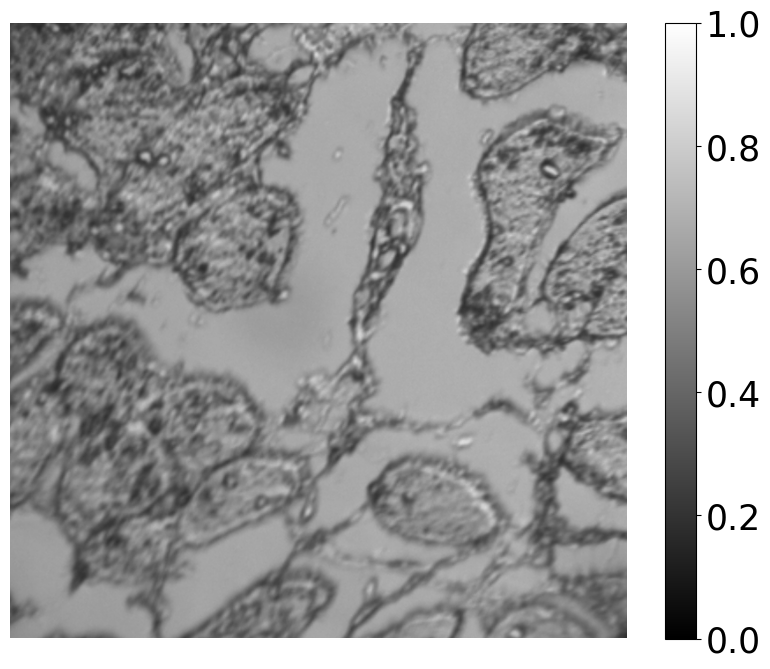

In [17]:
plt.figure(figsize=(10, 8))
plt.imshow(I0_float[0:700,0:700], cmap='gray',vmin=0,vmax=1)
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.show()




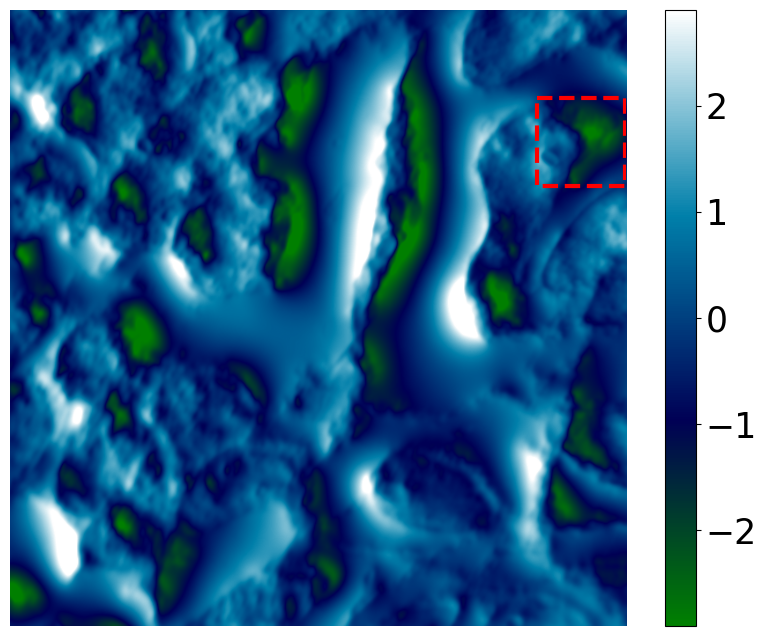

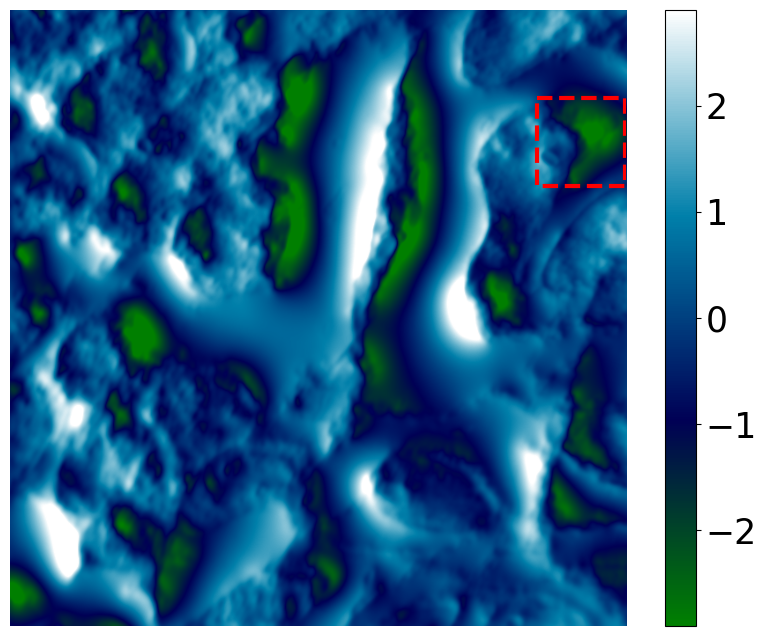

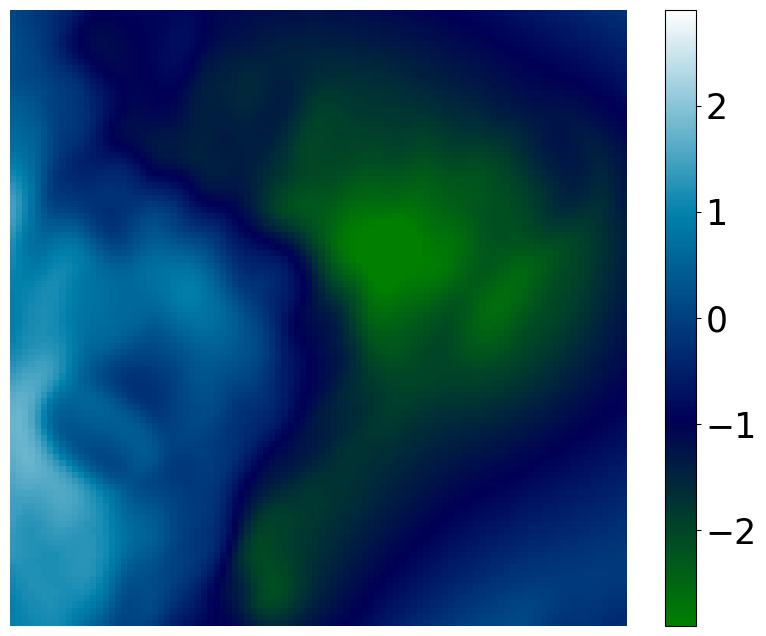

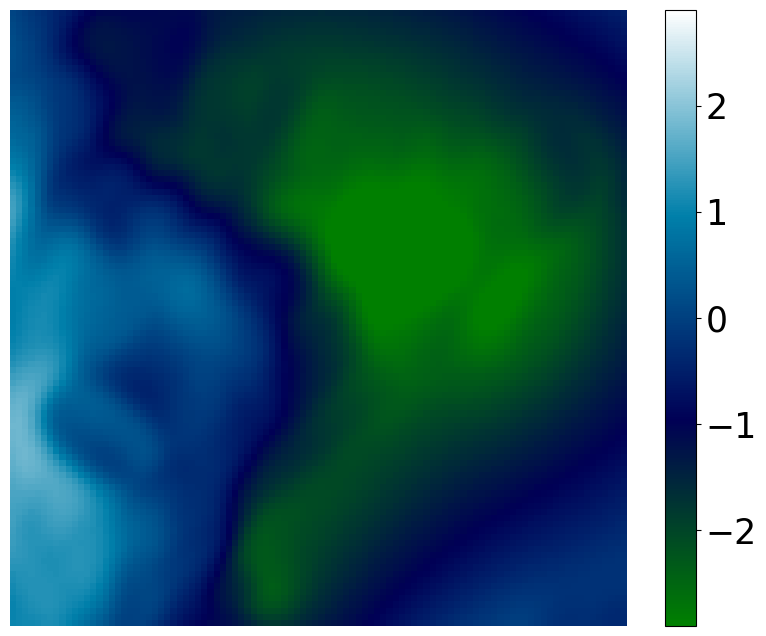

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

ROI_Y_START = 100
ROI_Y_END = 200
ROI_X_START = 598
ROI_X_END = ROI_X_START +100

RECT_HEIGHT = ROI_Y_END - ROI_Y_START
RECT_WIDTH = ROI_X_END - ROI_X_START

V_MIN = -2.9
V_MAX = 2.9


fig1, ax1 = plt.subplots(figsize=(10, 8))
img1 = Phi_1.get()[0:700, 0:700]
im1 = ax1.imshow(img1, cmap='ocean', vmin=V_MIN, vmax=V_MAX)
ax1.axis('off')


rect1 = patches.Rectangle(
    (ROI_X_START, ROI_Y_START),
    RECT_WIDTH,
    RECT_HEIGHT,
    linewidth=3,
    edgecolor='red',
    linestyle='--',
    facecolor='none'
)
ax1.add_patch(rect1)

cbar1 = fig1.colorbar(im1)
cbar1.ax.tick_params(labelsize=25)
# ax1.set_title('Phi_1 (Th=1.0) with ROI', fontsize=20)
plt.show()
print()

fig2, ax2 = plt.subplots(figsize=(10, 8))
img2 = Phi_1_8.get()[0:700, 0:700]
im2 = ax2.imshow(img2, cmap='ocean', vmin=V_MIN, vmax=V_MAX)
ax2.axis('off')

rect2 = patches.Rectangle(
    (ROI_X_START, ROI_Y_START),
    RECT_WIDTH,
    RECT_HEIGHT,
    linewidth=3,
    edgecolor='red',
    linestyle='--',
    facecolor='none'
)
ax2.add_patch(rect2)

cbar2 = fig2.colorbar(im2)
cbar2.ax.tick_params(labelsize=25)
# ax2.set_title('Phi_1.8 (Th=1.8) with ROI', fontsize=20)
plt.show()
print()
fig1_zoom, ax1_zoom = plt.subplots(figsize=(10, 8))
img1_zoom = Phi_1.get()[ROI_Y_START:ROI_Y_END, ROI_X_START:ROI_X_END]
im1_zoom = ax1_zoom.imshow(img1_zoom, cmap='ocean', vmin=V_MIN, vmax=V_MAX)
ax1_zoom.axis('off')

cbar1_zoom = fig1_zoom.colorbar(im1_zoom)
cbar1_zoom.ax.tick_params(labelsize=25)
# ax1_zoom.set_title(f'Phi_1 (Th=1.0) Zoom ({ROI_Y_START}:{ROI_Y_END}, {ROI_X_START}:{ROI_X_END})', fontsize=20)
plt.show()

print()
fig2_zoom, ax2_zoom = plt.subplots(figsize=(10, 8))
# Slicing para mostrar solo la región de interés
img2_zoom = Phi_1_8.get()[ROI_Y_START:ROI_Y_END, ROI_X_START:ROI_X_END]
im2_zoom = ax2_zoom.imshow(img2_zoom, cmap='ocean', vmin=V_MIN, vmax=V_MAX)
ax2_zoom.axis('off')

cbar2_zoom = fig2_zoom.colorbar(im2_zoom)
cbar2_zoom.ax.tick_params(labelsize=25)
# ax2_zoom.set_title(f'Phi_1.8 (Th=1.8) Zoom ({ROI_Y_START}:{ROI_Y_END}, {ROI_X_START}:{ROI_X_END})', fontsize=20)
plt.show()

/tmp/ipython-input-2665765960.py:20: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 2 Axes> than <Figure size 1000x800 with 2 Axes> which fig.colorbar is called on.
  cbare = fig1.colorbar(ime)


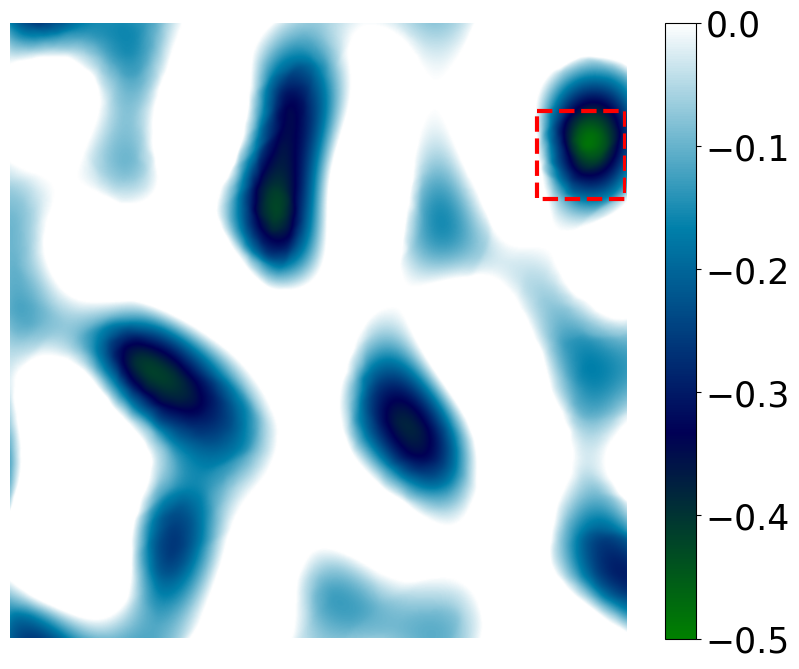

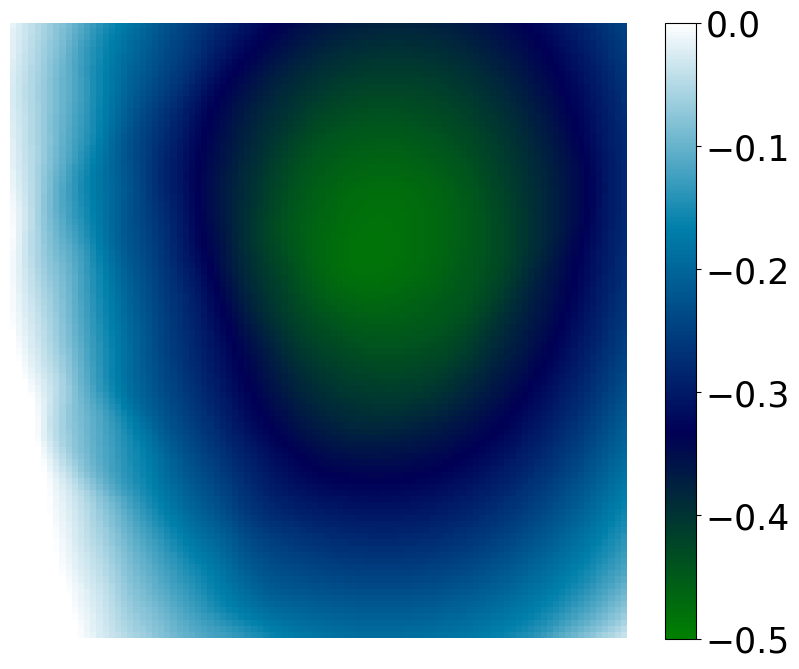

In [19]:
diff_image = img2.astype(float) - img1.astype(float)

fige, axe = plt.subplots(figsize=(10, 8))
imge = diff_image
ime = axe.imshow(imge, cmap='ocean', vmin = -0.5, vmax = 0)
axe.axis('off')


recte = patches.Rectangle(
    (ROI_X_START, ROI_Y_START),
    RECT_WIDTH,
    RECT_HEIGHT,
    linewidth=3,
    edgecolor='red',
    linestyle='--',
    facecolor='none'
)
axe.add_patch(recte)

cbare = fig1.colorbar(ime)
cbare.ax.tick_params(labelsize=25)
# ax1.set_title('Phi_1 (Th=1.0) with ROI', fontsize=20)
plt.show()
print()


fig4_zoom, ax4_zoom = plt.subplots(figsize=(10, 8))
img4_zoom = diff_image[ROI_Y_START:ROI_Y_END, ROI_X_START:ROI_X_END]
img4_zoom = ax4_zoom.imshow(img4_zoom, cmap='ocean', vmin = -0.5, vmax = 0)
ax4_zoom.axis('off')

cbar4_zoom = fig4_zoom.colorbar(img4_zoom)
cbar4_zoom.ax.tick_params(labelsize=25)
# ax2_zoom.set_title(f'Phi_1.8 (Th=1.8) Zoom ({ROI_Y_START}:{ROI_Y_END}, {ROI_X_START}:{ROI_X_END})', fontsize=20)
plt.show()



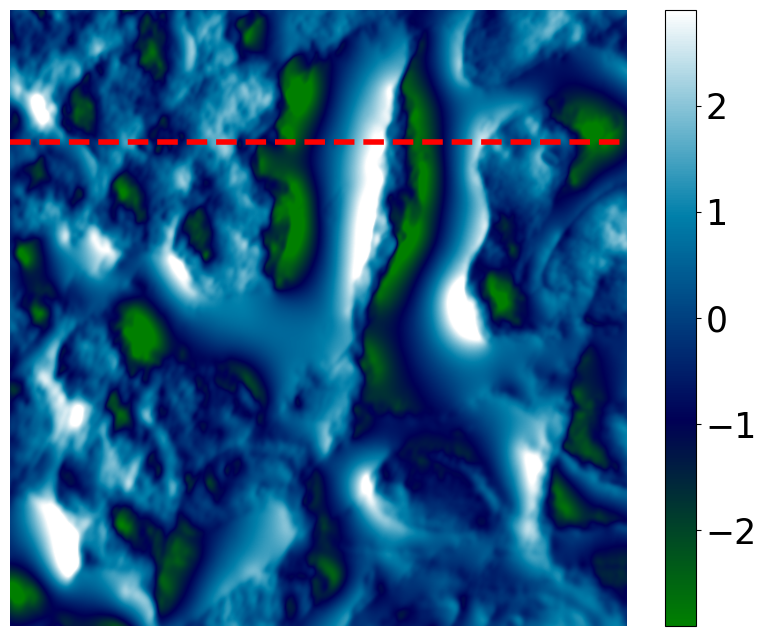

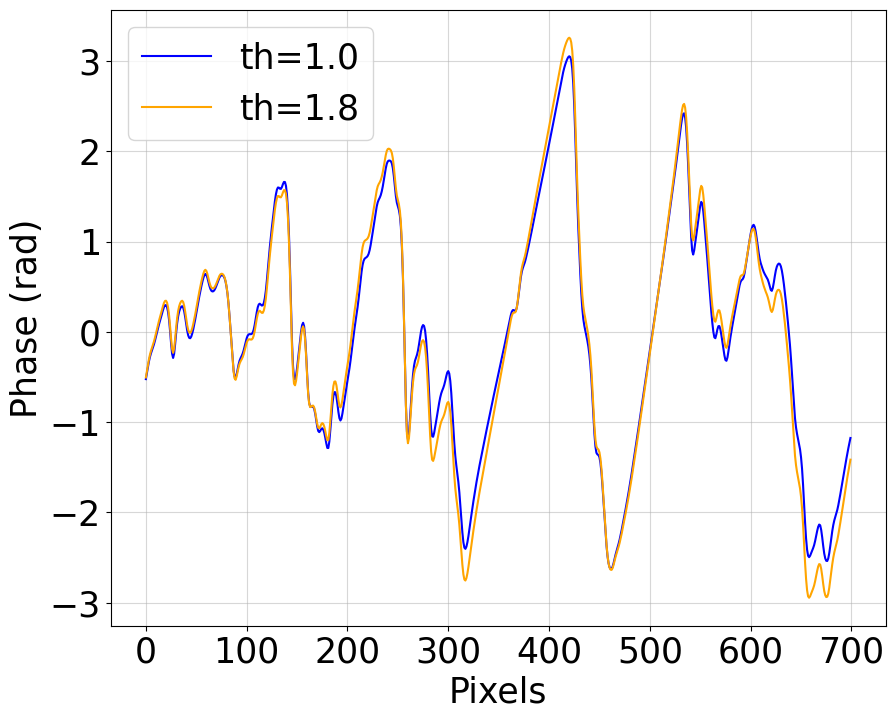

In [20]:
image_data = Phi_1_8.get()[0:700,0:700]
ROW_INDEX = 150

plt.figure(figsize=(10, 8))
plt.imshow(image_data, cmap='ocean', vmin = V_MIN, vmax=V_MAX)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
plt.axis('off')

plt.axhline(y=ROW_INDEX, color='red', linestyle='--', linewidth=4)

# plt.title(f'Imagen con Línea de Perfil en Fila {ROW_INDEX}', fontsize=16)
plt.show()



image_data = Phi_1.get()[0:700, 0:700]

horizontal_profile = image_data[ROW_INDEX, :]

position = np.arange(len(horizontal_profile))

profile_1 = Phi_1.get()[ROW_INDEX, 0:700]
profile_1_8 = Phi_1_8.get()[ROW_INDEX, 0:700]

plt.figure(figsize=(10, 8))
plt.plot(position, profile_1, label='th=1.0', color='blue')
plt.plot(position, profile_1_8, label='th=1.8', color='orange')
# plt.title(f'Comparación de Perfiles en Fila {ROW_INDEX}', fontsize=16)
plt.xlabel('Pixels', fontsize=25)
plt.ylabel('Phase (rad)', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(True, which="both", alpha=0.5)
plt.legend(fontsize=25)
plt.show()



# perfil


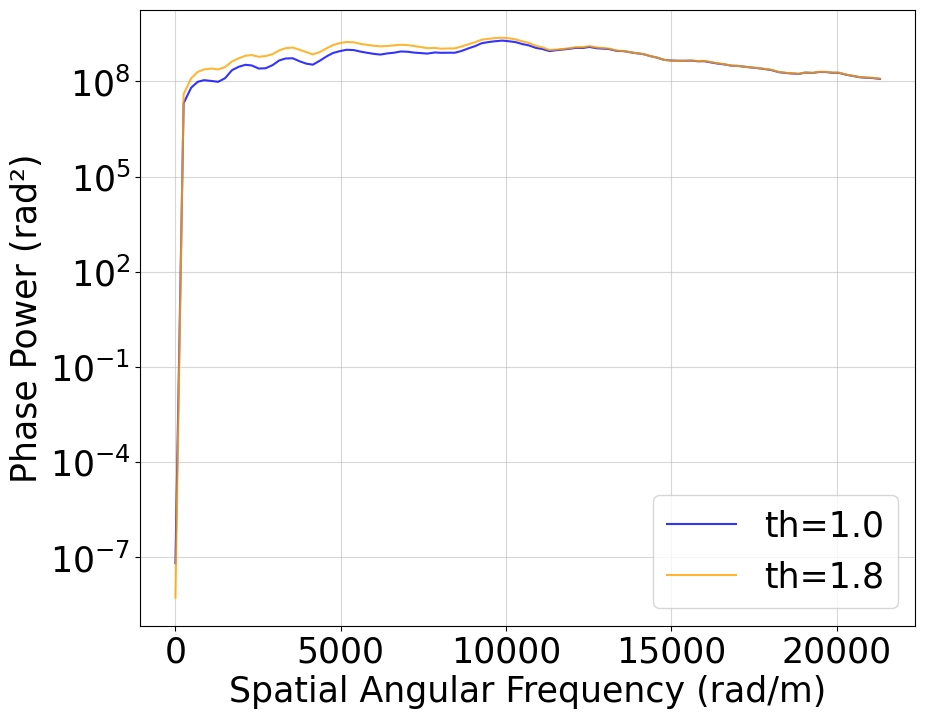

In [21]:

def get_radial_psd_padded(image_data, pixel_size, padding_factor=2):

    h_orig, w_orig = image_data.shape


    new_h = int(2**np.ceil(np.log2(h_orig * padding_factor)))
    new_w = int(2**np.ceil(np.log2(w_orig * padding_factor)))

    padded_data = np.zeros((new_h, new_w), dtype=image_data.dtype)
    start_h = (new_h - h_orig) // 2
    start_w = (new_w - w_orig) // 2
    padded_data[start_h:start_h + h_orig, start_w:start_w + w_orig] = image_data

    f = np.fft.fft2(padded_data)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)**2

    h, w = padded_data.shape

    fx = np.fft.fftfreq(w, pixel_size)
    fy = np.fft.fftfreq(h, pixel_size)

    FU, FV = np.meshgrid(fx, fy)
    FU_shifted = np.fft.fftshift(FU)
    FV_shifted = np.fft.fftshift(FV)

    fr = np.hypot(FU_shifted, FV_shifted)
    y, x = np.ogrid[-h//2:h//2, -w//2:w//2]
    r = np.hypot(x, y).astype(int)

    nr = np.bincount(r.ravel())
    tbin = np.bincount(r.ravel(), magnitude_spectrum.ravel())
    radial_profile = tbin / nr

    freq_bins_linear = np.bincount(r.ravel(), fr.ravel()) / nr
    freqs_linear = freq_bins_linear[0:len(radial_profile)]

    freqs_angular = 2 * np.pi * freqs_linear

    energy_cumsum = np.cumsum(radial_profile)
    energy_cumsum /= energy_cumsum[-1]

    return freqs_angular, radial_profile, energy_cumsum

paddd = 5

freqs_1, psd_1, energy_1 = get_radial_psd_padded(Phi_1.get(), pixelsize, padding_factor=paddd)
freqs_2, psd_2, energy_2 = get_radial_psd_padded(Phi_1_8.get(), pixelsize, padding_factor=paddd)


plt.figure(figsize=(10, 8))
max_ind_freq = 21*paddd
plt.semilogy(freqs_1[0:max_ind_freq], psd_1[0:max_ind_freq], label='th=1.0', color='blue', alpha=0.8)
plt.semilogy(freqs_2[0:max_ind_freq], psd_2[0:max_ind_freq], label='th=1.8', color='orange', alpha=0.8)

# plt.title('Phase Power Spectral Density', fontsize=16)
plt.xlabel('Spatial Angular Frequency (rad/m)', fontsize=25)
plt.ylabel('Phase Power (rad²)', fontsize=25)
plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(True, which="both", alpha=0.5)
plt.show()



In [22]:
omega_max = 7500.0

indices = freqs_1 <= omega_max

freqs_1_filtered = freqs_1[indices]
psd_1_filtered = psd_1[indices]
freqs_2_filtered = freqs_2[indices]
psd_2_filtered = psd_2[indices]

integral_1 = np.trapezoid(psd_1_filtered, freqs_1_filtered)
integral_2 = np.trapezoid(psd_2_filtered, freqs_2_filtered)

print(f"Integral de PSD (Th=1.0) entre 0 y {omega_max} rad/m: {integral_1:.6e}")
print(f"Integral de PSD (Th=1.8) entre 0 y {omega_max} rad/m: {integral_2:.6e}")
print( (integral_2 - integral_1)/integral_1) # es un 86% más de energía en las frecuencias bajas


Integral de PSD (Th=1.0) entre 0 y 7500.0 rad/m: 3.587629e+12
Integral de PSD (Th=1.8) entre 0 y 7500.0 rad/m: 6.677037e+12
0.8611279014986899


In [23]:

def find_cutoff_frequency(freqs, energy_cumsum_normalized, percentile=0.9):
    """
    Halla la frecuencia donde la energía acumulada alcanza un percentil dado.
    """
    if energy_cumsum_normalized.size == 0:
        return np.nan

    idx_cutoff = np.argmax(energy_cumsum_normalized >= percentile)

    if energy_cumsum_normalized[idx_cutoff] < percentile:

        return freqs[-1]

    return freqs[idx_cutoff]


freqs_1, psd_1, energy_1 = get_radial_psd_padded(Phi_1.get(), pixelsize, padding_factor=5)
freqs_2, psd_2, energy_2 = get_radial_psd_padded(Phi_1_8.get(), pixelsize, padding_factor=5)

freq_90_1 = find_cutoff_frequency(freqs_1, energy_1, percentile=0.9)
freq_90_2 = find_cutoff_frequency(freqs_2, energy_2, percentile=0.9)

print(f"Frecuencia al 90% (th=1.0 - MS-TIE): {freq_90_1:.2f} rad/m")
print(f"Frecuencia al 90% (th=1.8 - EMS-TIE): {freq_90_2:.2f} rad/m")

Frecuencia al 90% (th=1.0 - MS-TIE): 17847.84 rad/m
Frecuencia al 90% (th=1.8 - EMS-TIE): 16402.59 rad/m
